This notebook contains some parts from the notebook corresponding to the article:Filtering Relevant Flood Images on Twitter using Content-based Filters. To use it correctly visit https://github.com/cvjena/twitter-flood-dataset

 Filtering Relevant Flood Images on Twitter using Content-based Filters

> Björn Barz, Kai Schröter, Ann-Christin Kra, and Joachim Denzler.  
> Workshop on "Machine Learning Advances Environmental Science (MAES)" at the "International Conference on Pattern Recognition (ICPR)" 2020.


This is VGG notebook, however you can use as a ResNet one. You need to change: general_treshold = 0.39, and choose weights to initialize the model 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/Thesis/twitter-flood-dataset-master (1)/utils1.py' '/usr/local/lib/python3.7/dist-packages'

Mounted at /content/drive


In [ ]:
import json
import os.path
from glob import glob
import numpy as np
import pandas as pd
import keras
import keras_preprocessing.image
import sklearn.metrics

import matplotlib.pyplot as plt
import IPython.display

from utils1 import load_and_crop_img, predict_with_orientation as predict
keras_preprocessing.image.iterator.load_img = load_and_crop_img# patch image loading function from keras to support cropping
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn import metrics
general_treshold = 0.33

# 1.Downloading datasets

In [ ]:
!!cp /content/drive/MyDrive/Thesis/model/kaggle.json ./kaggle.json
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           6645        207  1.0              
kaggleashwin/population-dataset                                World Population by Countries Dataset (1960-2021)    69KB  2022-08-31 05:30:26           1699         71  1.0              
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03          12489        317  1.0              
pant

In [ ]:
!kaggle datasets download -d aswin1871/cyclonewildfireflood-and-earthquake
!unzip cyclonewildfireflood-and-earthquake.zip

In [ ]:
!kaggle datasets download -d saurabhshahane/roadway-flooding-image-dataset
!unzip roadway-flooding-image-dataset.zip #441

In [ ]:
!kaggle datasets download -d tunhunhminh/demodata # city problems
!unzip demodata.zip

# 2. Evaluation functions

The function which shows true positive, false positive, false negative, true negative classified images (by the color of its frame)

In [ ]:
def show_pred_img(csvfilname, path_to_files, threshold):

  df = pd.read_csv(csvfilname)
  tp = (df[((df["prob_flood"]>threshold) & (df["class_binary"] == 1))], "lime") # true positive
  fn = (df[((df["prob_flood"]<threshold) & (df["class_binary"] == 1))], "yellow") # false positive
  fp = (df[((df["prob_flood"]>threshold) & (df["class_binary"] == 0))], "red") # false negative
  tn = (df[((df["prob_flood"]<threshold) & (df["class_binary"] == 0))], "blue") # true negative
  print("tp len: ",len(tp[0]))
  print("fp len: ",len(fp[0]))
  print("fn len: ",len(fn[0]))
  print("tn len: ",len(tn[0]))
  for ret in [tp,fp,fn,tn]:
    if (len(ret[0]) > 0):
      fig_rows = min(4, int(np.ceil(len(ret[0]) / 5)))
      fig, axes = plt.subplots(fig_rows, 5, figsize=(13, 2 * fig_rows))
      for f_n, ax in zip(ret[0]['image_id'], axes.ravel()):
          img_id = os.path.splitext(os.path.basename(path_to_files+f_n))[0]
          ax.imshow(plt.imread(path_to_files+f_n), interpolation='bicubic')
          ax.set_xticks([])
          ax.set_yticks([])
          for pos in ['top', 'bottom', 'right', 'left']:
            ax.spines[pos].set_edgecolor(ret[1])
            ax.spines[pos].set_linewidth(2)
  fig.tight_layout()
  plt.show()

Roc curve function

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

def roc_curve_func(y_test, y_score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure()
  lw = 2
  plt.plot(
      fpr[1],
      tpr[1],
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc[1],
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

Fbeta function

In [ ]:
def fbeta_curve(csv_filename, b=0.5):
    data = pd.read_csv(csv_filename)
    fscores = []
    for i in np.arange(0.1,1.0,0.01):
      data["prob_class"] = data['prob_flood'].apply(lambda x: 1 if x > i else 0)
      fscores.append(fbeta_score(data["class_binary"], data["prob_class"], average='micro', beta=b))
    plt.plot(np.arange(0.1,1.0,0.01),fscores,label='F-scores with beta = {}'.format(b))
    plt.xlabel("Probabilty threshold")
    plt.ylabel("Fbeta score")
    plt.title("'F-scores with beta = {}'.format(b)")
    plt.legend(loc="lower right")
    plt.show()

Evaluation function unites all quantitive functions 

In [ ]:
def evaluation(csv_filename,threshold=0.5,balancing_samples=0):

  cycl_eval = pd.read_csv(csv_filename)
  cycl_eval['not_class_binary'] = cycl_eval['class_binary'].apply(lambda x: 1 if x==0  else 0)
  roc_curve_func(cycl_eval[['class_binary','not_class_binary']].to_numpy(),cycl_eval[['prob_flood','prob_not_flood']].to_numpy())
  
  prec, recall, _ = precision_recall_curve(cycl_eval['class_binary'], cycl_eval['prob_flood'])
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
  plt.show()
  cycl_eval['threshold'] = cycl_eval['prob_flood'].apply(lambda x: 1 if x>threshold else 0)
  print(metrics.classification_report(cycl_eval['class_binary'],cycl_eval['threshold']))
  
  # precision, recall, _ = precision_recall_curve(cycl_eval['class_binary'], cycl_eval['prob_flood'])
  # ap = average_precision_score(cycl_eval['class_binary'], cycl_eval['prob_flood'])
  # plt.plot(recall, precision, label='Flood (AP: {:.1%})'.format(ap), linewidth=1)
  
  fbeta_curve(csv_filename)
  if (balancing_samples != 0 ):
    print("Balanced roc curve")
    only_floods = cycl_eval[cycl_eval['class_binary']==1]
    only_not_floods = cycl_eval[cycl_eval['class_binary']!=1]
    shuffled = only_not_floods.sample(n = balanced)
    balanced = pd.concat([only_floods,shuffled])
    roc_curve_func(balanced[['class_binary','not_class_binary']].to_numpy(),balanced[['prob_flood','prob_not_flood']].to_numpy())

    prec, recall, _ = precision_recall_curve(balanced['class_binary'], balanced['prob_flood'])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    print(metrics.classification_report(balanced['class_binary'],balanced['threshold']))

In [ ]:
from math import exp
def softmax(prob_flood,prob_4):
  prob = exp(prob_flood)/(exp(prob_flood)+exp(prob_4))
  return prob

# 3.Model initalization

We also need to determine their orientation, since resizing will differ between images taken in landscape and portrait mode.

In [ ]:
def landscaping(path_to_dataset):
  filenames = []
  corrupted_images = list()
  filenames += keras_preprocessing.image.list_pictures(path_to_dataset)
  data = pd.DataFrame(columns = ['filename' , 'landscape'])
  err = 0
  for fn in filenames:
    try:
      h = plt.imread(fn).shape[0]
      w = plt.imread(fn).shape[1]
      data = data.append({'filename' : fn, 'landscape': 1 if w >= h else 0}, ignore_index=True)
    except:
      corrupted_images.append(fn)
      err+=1
  print("err = {}".format(err))
  print('Found {} images.'.format(len(data)))
  return data, corrupted_images

Set up Image Pre-processing

In [ ]:
img_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, featurewise_std_normalization=False,
    preprocessing_function=lambda img: img[:,:,::-1]  # RGB to BGR conversion
)
img_generator.mean = np.array([103.939, 116.779, 123.68])

Downloading the model: ResNet-50 or VGG-16(`rn50` with `vgg16`).

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Thesis/twitter-flood-dataset-master (1)/models/flood_relevance.vgg16.h5', compile=False)
# thresholds = np.array([-0.0677, -0.18, 0.011])  # Classification thresholds for the 3 classes for ResNet-50
thresholds = np.array([-0.145, -0.2835, -0.1408])  # Classification thresholds for the 3 classes for VGG-16

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

<h4> Function to predict images with their orientation

In [ ]:
def land_port_prediction(model, img_generator, data):
  pred_landscape = None
  pred_portrait = None
  if (data[data['landscape']==1].shape[0] != 0):
    pred_landscape = model.predict_generator(img_generator.flow_from_dataframe(
        data[data['landscape']==1], class_mode=None, shuffle=False,
        interpolation='bicubic:center-full', target_size=(512,768), batch_size=8
    ), verbose=True, workers=8, use_multiprocessing=True, max_queue_size=32)
  if (data[data['landscape']==0].shape[0] != 0):
    pred_portrait = model.predict_generator(img_generator.flow_from_dataframe(
        data[data['landscape']==0], class_mode=None, shuffle=False,
        interpolation='bicubic:center-full', target_size=(768,512), batch_size=8
    ), verbose=True, workers=8, use_multiprocessing=True, max_queue_size=32)

  pred = np.ndarray((len(data),) + pred_landscape.shape[1:], dtype=pred_landscape.dtype)
  if (data[data['landscape']==1].shape[0] != 0):
    pred[np.asarray(data[data['landscape']==1].index)] = pred_landscape
  if (data[data['landscape']==0].shape[0] != 0):
    pred[np.asarray(data[data['landscape']==0].index)] = pred_portrait
    
  return pred

# 4 Prediction and Evaluation

## 4.1 Twitter dataset

### 4.1.2 Prediction

In [ ]:
classnames = ['Flooding', 'Depth', 'Pollution']
datasets = ['harz17', 'rhine18']

# Load annotations
annotations = {}
for ds in datasets:
    with open('/content/drive/MyDrive/Thesis/twitter-flood-dataset-master (1)/{}.json'.format(ds)) as f:
        annotations.update(json.load(f))

# Determine set of relevant images for each class
twitter_rel = { classname : set() for classname in classnames } # made dictionary with three keys: FLooding, Depth, Pollution
for img_id, annot in annotations.items():
    for classname in classnames:
        if annot['Rel' +  classname]:
            twitter_rel[classname].add(img_id)

for classname, rel in twitter_rel.items():
    print('{}: {} relevant images'.format(classname, len(rel)))
print(twitter_rel)

Flooding: 1064 relevant images
Depth: 594 relevant images
Pollution: 12 relevant images
{'Flooding': {'DTBYUsvW0AEGIGf', 'DSzm5aiVwAENbKx', 'DSt5fInXUAEJZ1U', 'N9XK9Xy4si2AWDKu', 'DUclihnVAAAmjtq', 'DSoMBN1X0AEbB0q', 'DTwn-6NXcAYcxP0', 'DS8k8VlW0AASQql', 'DS-ILRDW0AEUSHM', 'DFqvNBVXYAE4aE2', 'YC1icxZIWct0qc01', '7GORYObbw6oKvm5G', 'DT5b4ZHVMAA3mQY', 'DS4hfKJW0AA4E0A', 'DUogI3QW4AE35EG', 'DFnTAJbWsAAtuD_', 'PcO8Vc6d1ISFFdl8', 'DF6h_PiWsAALDue', 'DTSSNjdWsAMdPa6', 'DSo5E0RXUAAJaz6', 'DSy18dxX0AkTCze', 'DS7qAN0X0AARxum', 'DUoAXJFX4AA-n2D', 'DFvWmfyXkAAotvW', 'DS8gZNiX0AAAt0g', 'DSuIcxiWsAAOMJ6', 'DTCqoiVWAAE7n1s', 'DS7jBd1XkAAepFN', 'DUX-EQ9WkAAF3bM', 'DSwQDblU0AAbkzJ', 'DFuelpNXkAAGBDA', 'DEO_JnnU0AETkF1', 'DFcRLbSXUAAIaZz', 'DFty8qnU0AABCQT', 'DUjs3rBW0AEbatv', 'DUqiS7wVAAAf1Ay', 'DShw4DIWkAEw811', 'DS2tEhRWAAAevLB', 'DUpcIm5WAAAsXJ1', 'DFnJiQxXkAAXZi8', 'DF1VlZkXkAA00QR', 'DSi4WRyXcAApWVY', 'DTBAWHdWsAYUkKi', 'DStbeczW0AA0IPM', 'DS16UhsWAAAtS-e', 'DTHApXdWAAEF8aP', 'DTHhecQX0AANG6M', '

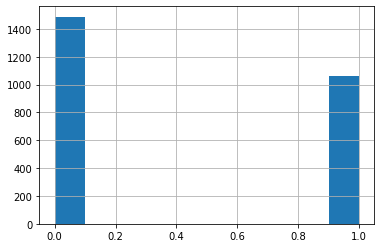

In [ ]:
url_dataset = pd.read_csv("/content/drive/MyDrive/Thesis/model/url_dataset.csv")

def change_library(x):
  current_path = "/content/drive/MyDrive/Thesis/model/twitter_dataset/"+x[0]+".jpg"
  destination0 ="/content/drive/MyDrive/Thesis/model/twitter_dataset/0/"+x[0]+".jpg"
  destination1 = "/content/drive/MyDrive/Thesis/model/twitter_dataset/1/"+x[0]+".jpg"
  if x[1] == 1:
    os.replace(current_path, destination0)
  else:
    os.replace(current_path,  destination1)
#url_dataset[['id','Class']].apply(change_library, axis=1)
url_dataset["Class"].hist()

In [ ]:
# data, corrupted_images = landscaping("/content/drive/MyDrive/Thesis/model/twitter_dataset") 
# for fn in corrupted_images:
#   os.remove(fn)

# data.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset_landscaped_data.csv")

err = 0
Found 2349 images.


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset_landscaped_data.csv")

In [ ]:
predictions = land_port_prediction(model, img_generator, data)
for_scv = pd.DataFrame(columns = ['prob_flood','prob_2','prob_3','prob_4'])
for p in predictions:
  for_scv = for_scv.append({'prob_flood' : p[0], 'prob_2':p[1],'prob_3':p[2],'prob_4':p[3]}, ignore_index=True )
for_scv.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vggpredictions_twitter_model_2.csv")

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vggpredictions_twitter_model_2.csv")
data.head()

,Unnamed: 0,prob_flood,prob_2,prob_3,prob_4
0,0,-1.877999,-1.801320,-2.322142,1.885683
1,1,0.811996,-0.211096,-0.578039,-1.020403
2,2,-0.947588,-1.050134,-1.486355,0.920130
3,3,-1.477347,-1.667684,-2.999938,1.527606
4,4,-2.364407,-2.004966,-1.789694,1.629656


Transforming predictions into probabistic space flooding/not flooding

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vggpredictions_twitter_model_2.csv")
data['prob_flood_percent'] = data.apply(lambda x: softmax(x.prob_flood, x.prob_4), axis=1)
data["prob_not_flood_percent"] = data.apply(lambda x: softmax(x.prob_4,x.prob_flood), axis=1)
# pdpred["prob_flood_percent"] = exp(pdpred["prob_flood"])/(exp(pdpred["prob_flood"])+exp(pdpred["prob_2"])+exp(pdpred["prob_3"])+exp(pdpred["prob_4"]))
# pdpred["prob_not_flood_percent"] = (exp(pdpred["prob_2"])+exp(pdpred["prob_3"])+exp(pdpred["prob_4"]))/(exp(pdpred["prob_flood"])+exp(pdpred["prob_2"])+exp(pdpred["prob_3"])+exp(pdpred["prob_4"]))
data1 = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset_landscaped_data.csv")
data = data.merge(data1)

def flooding(x):
  x = os.path.splitext(os.path.basename(x))[0]
  if x in twitter_rel["Flooding"]:
    x = 1
  else: 
    x = 0
  return x

data["class_binary"] = data["filename"].apply(flooding)
data = data.drop(columns=["prob_flood","prob_2","prob_3","prob_4","landscape","Unnamed: 0"])
data = data.rename(columns={"filename":"image_id","prob_flood_percent":"prob_flood", "prob_not_flood_percent":"prob_not_flood"})
data.to_csv("/content/drive/My Drive/Thesis/model/vgg-twit_dataset-with-classes.csv")

2349
2349


Sometimes images can be assigned to wrong direction, run this cell to swap directories in pandas dataframe

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Thesis/model/vgg-twit_dataset-with-classes.csv")
def change(x):
  if x.find("/0/") == -1:
    x = x.replace("/1/","/0/")
  else:
    x = x.replace("/0/","/1/")
  return x

data["image_id"] = data["image_id"].apply(change)
data.to_csv("/content/drive/My Drive/Thesis/model/vgg-twit_dataset-with-classes.csv")

### 4.1.2 Evaluation

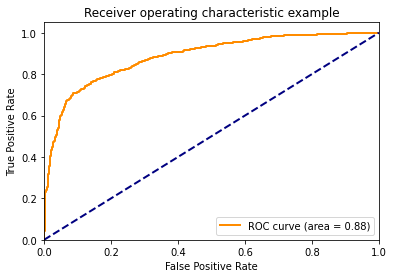

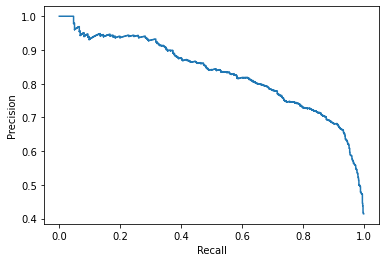

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1390
           1       1.00      0.03      0.05       959

    accuracy                           0.60      2349
   macro avg       0.80      0.51      0.40      2349
weighted avg       0.76      0.60      0.46      2349



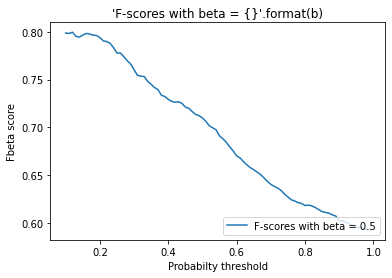

In [ ]:
evaluation("/content/drive/My Drive/Thesis/model/vgg-twit_dataset-with-classes.csv",0.9)

In [ ]:
show_pred_img("/content/drive/My Drive/Thesis/model/vgg-twit_dataset-with-classes.csv","",0.1)

## 4.2 CWFE dataset

### 4.2.1 Prediction

In [ ]:
# data, corrupted_images = landscaping("/content/Cyclone_Wildfire_Flood_Earthquake_Database/")
# data.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_cyclone-wildfire-with-classes.csv")
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_cyclone-wildfire-with-classes.csv")
predictions = land_port_prediction(model, img_generator, data)
for_scv = pd.DataFrame(columns = ['prob_flood' , 'prob_2','prob_3','prob_4'])
for p in predictions:
  for_scv = for_scv.append({'prob_flood' : p[0], 'prob_2':p[1],'prob_3':p[2],'prob_4':p[3]}, ignore_index=True )
for_scv.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_cyclone-wildfire-with-classes.csv")
print(predictions)

In [ ]:
def true_class(k):
  if (k.find('/Cyclone/') != -1):
    return 'c'
  elif (k.find('/Earthquake/') != -1):
    return 'e'
  elif (k.find('/Flood/') != -1):
    return 'f'
  else:
    return 'w'

In [ ]:
pdpred = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_cyclone-wildfire-with-classes.csv")
ann = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_cyclone-wildfire-with-classes.csv")
ann = ann.set_index('Unnamed: 0').join(pdpred.set_index('Unnamed: 0'))
ann['true_class'] = ann['filename'].apply(true_class)
ann['class_binary'] = ann['true_class'].apply(lambda x: 1 if x=='f' else 0)
ann['prob_flood_percent'] = ann.apply(lambda x: softmax(x.prob_flood, x.prob_4), axis=1)
ann["prob_not_flood_percent"] = ann.apply(lambda x: softmax(x.prob_4,x.prob_flood), axis=1)
ann = ann.drop(columns=["prob_flood","prob_2","prob_3","prob_4","landscape"])
ann = ann.rename(columns={"filename":"image_id","prob_flood_percent":"prob_flood", "prob_not_flood_percent":"prob_not_flood"})
ann.to_csv("/content/drive/My Drive/Thesis/model/vgg-cyclone-wildfire-with-classes.csv")
ann.head()
# predictions = pdpred.values.tolist()
# predictions = np.array(predictions)

,image_id,true_class,class_binary,prob_flood,prob_not_flood
Unnamed: 0,,,,,
0,/content/Cyclone_Wildfire_Flood_Earthquake_Dat...,f,1,0.185782,0.814218
1,/content/Cyclone_Wildfire_Flood_Earthquake_Dat...,f,1,0.640891,0.359109
2,/content/Cyclone_Wildfire_Flood_Earthquake_Dat...,f,1,0.885095,0.114905
3,/content/Cyclone_Wildfire_Flood_Earthquake_Dat...,f,1,0.919181,0.080819
4,/content/Cyclone_Wildfire_Flood_Earthquake_Dat...,f,1,0.029268,0.970732


### 4.2.2 Evaluation

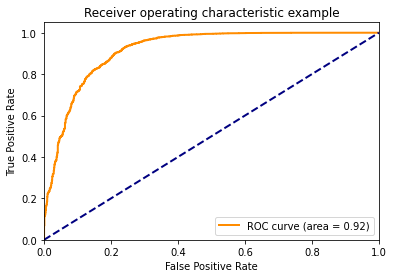

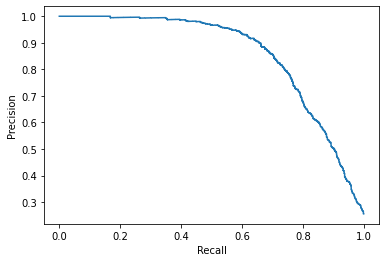

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      3355
           1       0.99      0.33      0.49      1073

    accuracy                           0.84      4428
   macro avg       0.91      0.66      0.70      4428
weighted avg       0.86      0.84      0.80      4428



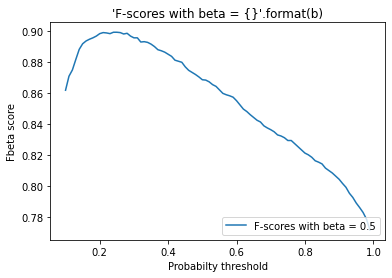

In [ ]:
evaluation("/content/drive/My Drive/Thesis/model/vgg-cyclone-wildfire-with-classes.csv",threshold=0.7)

In [ ]:
show_pred_img("/content/drive/My Drive/Thesis/model/vgg-cyclone-wildfire-with-classes.csv","",0.25)

## 4.3 Roadway flooding 

### 4.3.1 Prediction

In [ ]:
data, corrupted_images = landscaping("/content/Dataset/images")
data.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_roadway-with-classes.csv")

err = 0
Found 441 images.


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_roadway-with-classes.csv")
data.head()

,Unnamed: 0,filename,landscape
0,0,/content/Dataset/images/image_48.jpg,1
1,1,/content/Dataset/images/image_147.jpg,1
2,2,/content/Dataset/images/image_170.jpg,1
3,3,/content/Dataset/images/image_279.jpg,1
4,4,/content/Dataset/images/image_198.jpg,1


In [ ]:
predictions = land_port_prediction(model, img_generator, data)
for_scv = pd.DataFrame(columns = ['prob_flood' , 'prob_2','prob_3','prob_4'])
for p in predictions:
  for_scv = for_scv.append({'prob_flood' : p[0], 'prob_2':p[1],'prob_3':p[2],'prob_4':p[3]}, ignore_index=True )
for_scv.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_roadway-with-classes.csv",index=False)
print(predictions)

Found 441 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


56/56 [==============================] - 42s 407ms/step
[[ 0.6134405  -0.13784283 -1.1566393  -0.9955236 ]
 [-0.16179544 -0.5257336  -1.039795   -0.2200133 ]
 [ 0.12655342 -0.14144301 -1.6574545  -0.3268001 ]
 ...
 [-0.32456914 -0.53539664 -0.96316564  0.13824314]
 [-0.2718088  -1.0631301  -0.49770266 -0.23247506]
 [-0.03403831 -0.6620497  -1.3138154  -0.37605834]]


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_roadway-with-classes.csv")
data1 = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_roadway-with-classes.csv")
data = data.merge(data1)
data["prob_flood_percent"] = data.apply(lambda x: softmax(x.prob_flood,x.prob_4),axis=1)
data["prob_not_flood"] = data.apply(lambda x: softmax(x.prob_4,x.prob_flood),axis=1)
data = data.drop(columns=["Unnamed: 0","prob_2","prob_3","landscape","prob_flood","prob_4"])
data = data.rename(columns={"prob_flood_percent":"prob_flood"})
data["class_binary"] = 1
data.to_csv("/content/drive/My Drive/Thesis/model/vgg-roadway-flooding-with-classes.csv",index=False)

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Thesis/model/vgg-roadway-flooding-with-classes.csv")
data.head()

,filename,prob_flood,prob_not_flood,class_binary
0,/content/Dataset/images/image_48.jpg,0.833268,0.166732,1
1,/content/Dataset/images/image_147.jpg,0.514550,0.485450,1
2,/content/Dataset/images/image_170.jpg,0.611436,0.388564,1
3,/content/Dataset/images/image_279.jpg,0.723647,0.276353,1
4,/content/Dataset/images/image_198.jpg,0.523638,0.476362,1


### 4.3.2 Evaluation 

In [ ]:
evaluation("/content/drive/My Drive/Thesis/model/vgg-roadway-flooding-with-classes.csv",threshold=0.7)

tp len:  423
fp len:  0
fn len:  18
tn len:  0


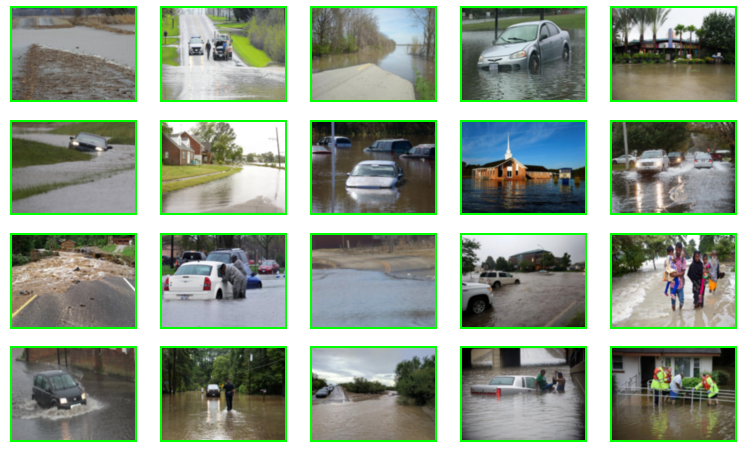

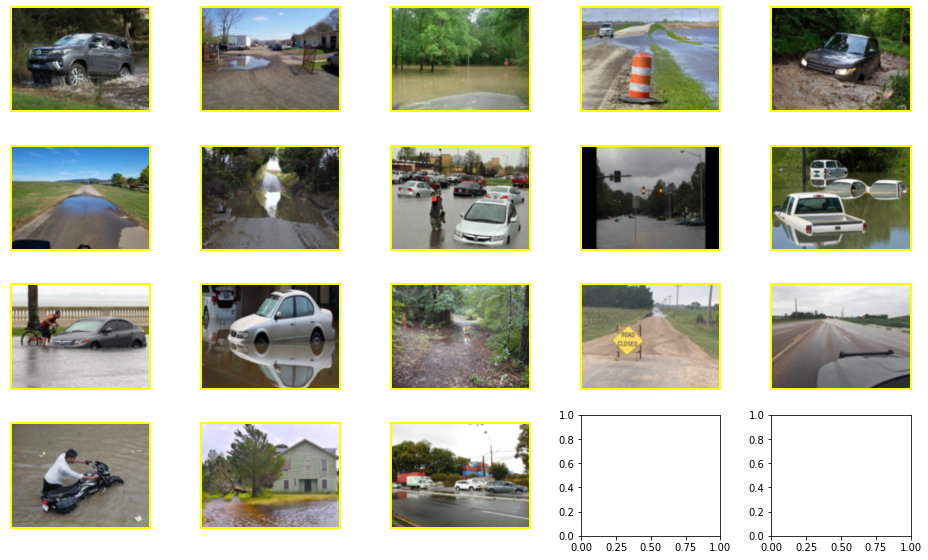

In [ ]:
show_pred_img("/content/drive/My Drive/Thesis/model/roadway-flooding-with-classes.csv","/content/Dataset/images/",0.2)

## 4.4 City problems

### 4.4.1 Prediction

In [ ]:
# data, corrupted_images = landscaping("/content/train")
# print('success')
# data.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_city-problems-list-train.csv")
data = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/landscape_git_city-problems-list-train.csv")

In [ ]:
data.head()

In [ ]:
predictions = land_port_prediction(model, img_generator, data)
for_scv = pd.DataFrame(columns = ['prob_flood' , 'prob_2','prob_3','prob_4'])
for p in predictions:
  for_scv = for_scv.append({'prob_flood' : p[0], 'prob_2':p[1],'prob_3':p[2],'prob_4':p[3]}, ignore_index=True )
for_csv = data.join(for_scv)
for_csv.to_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_city-problems-with-classes.csv")
print(predictions)

In [ ]:
for_csv.filename

0        /content/train/train/12379.jpg
1        /content/train/train/14553.jpg
2         /content/train/train/4842.jpg
3         /content/train/train/4107.jpg
4          /content/train/train/535.jpg
                      ...              
15218     /content/train/train/9353.jpg
15219     /content/train/train/2563.jpg
15220    /content/train/train/10105.jpg
15221      /content/train/train/699.jpg
15222     /content/train/train/9444.jpg
Name: filename, Length: 15223, dtype: object

In [ ]:
for_csv = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/vgggit_city-problems-with-classes.csv")
test = pd.read_csv('/content/train.csv')
test['image_id'] = test['image_id'].apply(lambda x: '/content/train/train/'+x)
for_csv = for_csv.rename(columns={"filename":"image_id"})
for_csv = for_csv.set_index('image_id').join(test.set_index('image_id'))
for_csv['class_binary'] = for_csv['label'].apply(lambda x: 1 if x==3 else 0)
for_csv["prob_flood_percent"] = for_csv.apply(lambda x: softmax(x.prob_flood,x.prob_4),axis=1)
for_csv["prob_not_flood"] = for_csv.apply(lambda x: softmax(x.prob_4,x.prob_flood),axis=1)
for_csv = for_csv.drop(columns=["Unnamed: 0","Unnamed: 0.1","prob_2","prob_3","landscape","prob_flood","prob_4","label"])
for_csv = for_csv.rename(columns={"prob_flood_percent":"prob_flood"})
for_csv.head()
for_csv.to_csv("/content/drive/My Drive/Thesis/model/vgg-city-problems-with-classes.csv") 
# for_csv = pd.read_csv("/content/drive/MyDrive/Thesis/model/twitter_dataset/git_city-problems-full.csv")

In [ ]:
for_csv.head()

,landscape,prob_flood,prob_2,prob_3,prob_4,label,binary_label
filename,,,,,,,
/content/train/train/12379.jpg,1,-1.337277,-1.226698,-0.316681,0.125886,6,False
/content/train/train/14553.jpg,1,-1.433807,-1.615691,-0.318955,0.379467,7,False
/content/train/train/4842.jpg,1,-1.327229,-0.999961,-0.894744,1.157294,1,False
/content/train/train/4107.jpg,1,-0.868103,-1.440802,-1.254194,0.677923,1,False
/content/train/train/535.jpg,0,-1.891364,-1.499079,-0.814433,1.317978,0,False


### 4.4.2 Evaluation

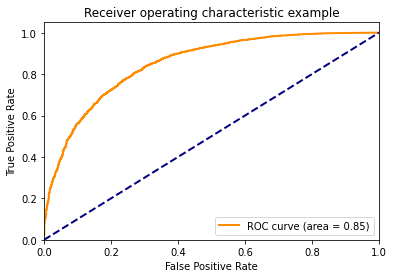

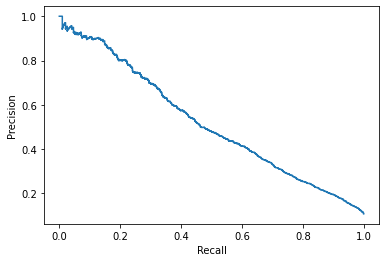

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     13613
           1       0.81      0.20      0.31      1610

    accuracy                           0.91     15223
   macro avg       0.86      0.59      0.63     15223
weighted avg       0.90      0.91      0.88     15223



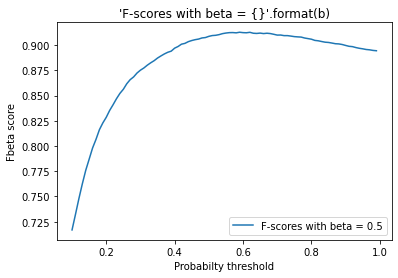

In [ ]:
evaluation("/content/drive/My Drive/Thesis/model/vgg-city-problems-with-classes.csv",threshold=0.7)

tp len:  89
fp len:  7
fn len:  1521
tn len:  13606


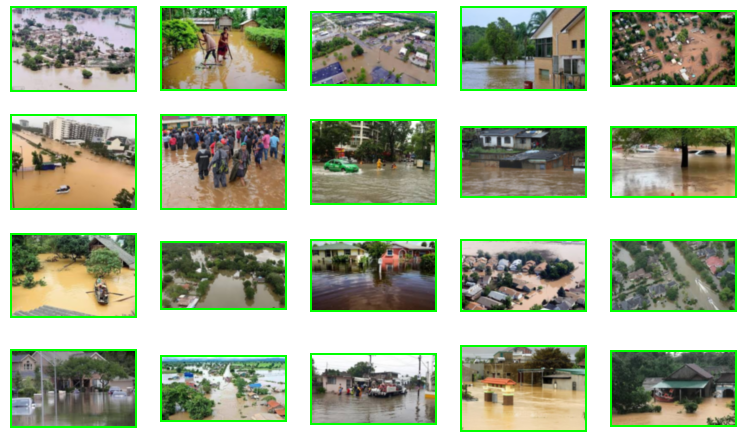

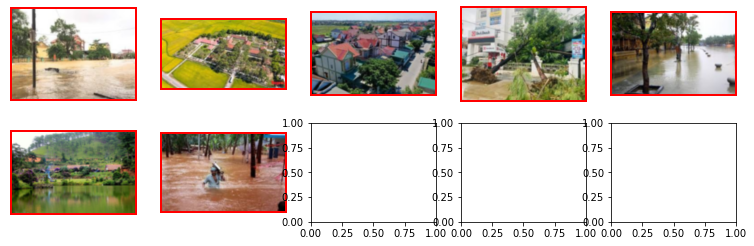

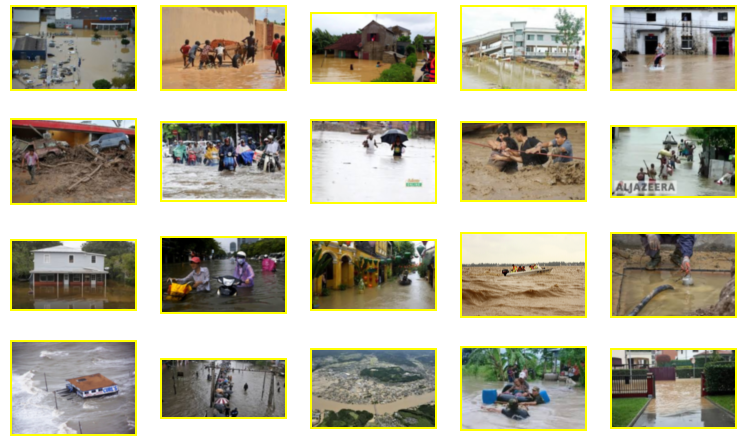

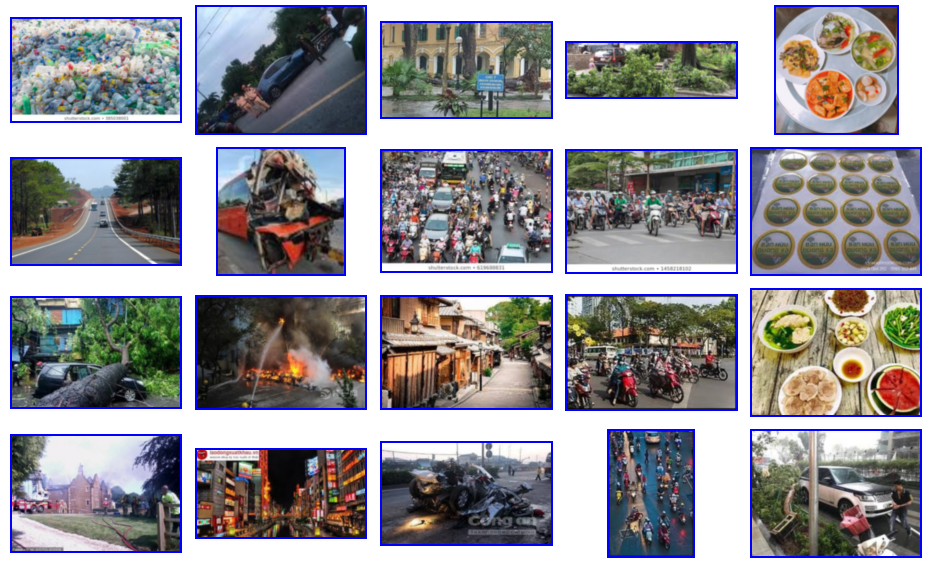

In [ ]:
show_pred_img("/content/drive/My Drive/Thesis/model/vgg-city-problems-with-classes.csv","",0.9)